In [1]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
import librosa
import matplotlib.pyplot as plt
from IPython.display import Audio 
from IPython.core.display import display
import pandas as pd

C:\Users\trick\AppData\Local\Temp\ipykernel_16688\3081543886.py:7: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display


Step 1: Split the dataset into training and testing sets

In [2]:
labels = {'angry': 0, 'fear': 1, 'happy': 2, 'sad': 3}

In [3]:
X = np.array([])
for folder in os.listdir('./data'):
    for file in os.listdir(f"./data/{folder}"):
        X = np.append(X, f"data/{folder}/{file}")
y = np.array([0]*100 + [1]*100 + [2]*100 + [3]*100)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

Step 2: Exploratory Data Analysis

In [5]:
rand_int = np.random.randint(3,100)
random_samples = X[rand_int::100]
random_samples[2] = X[rand_int+198]

In [6]:
for sample in random_samples:
    display(Audio(sample))

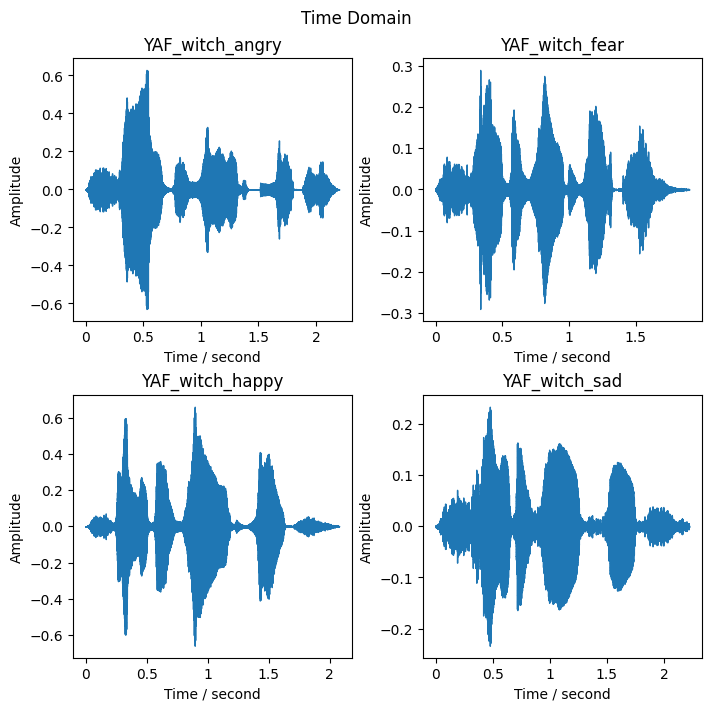

In [7]:
fig, axs = plt.subplots(2,2, constrained_layout=True, figsize=(7,7))
fig.suptitle("Time Domain")
for i,sample in enumerate(random_samples):
    signal, sample_rate = librosa.load(sample)
    if (i == 0):
        ax = axs[0,0]
    elif (i == 1):
        ax = axs[0,1]
    elif (i == 2):
        ax = axs[1,0]
    else:
        ax = axs[1,1]
    ax.set_title(sample.split('/')[2].split('.')[0])
    librosa.display.waveshow(y=signal, sr=sample_rate, ax=ax)
    ax.set_xlabel('Time / second')
    ax.set_ylabel('Amplitude')
plt.show()

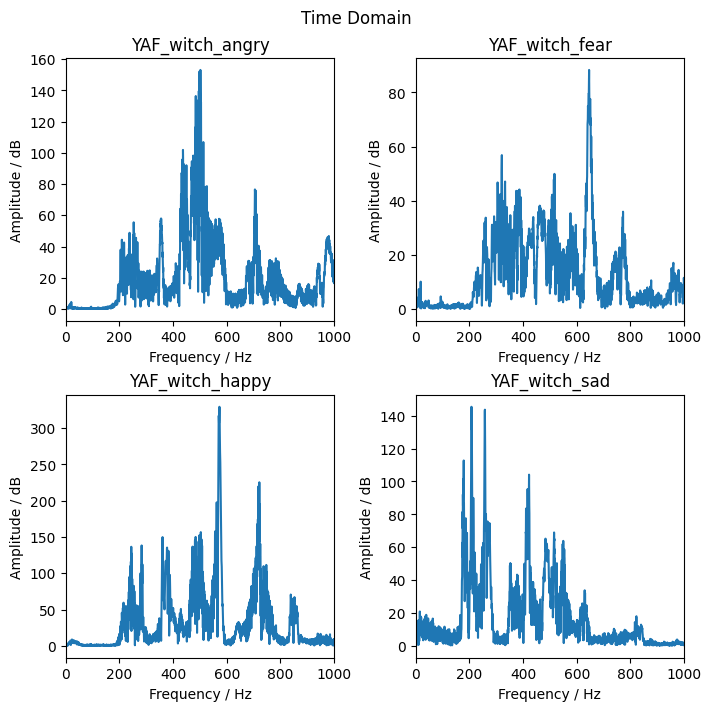

In [8]:
fig, axs = plt.subplots(2,2, constrained_layout=True, figsize=(7,7))
fig.suptitle("Time Domain")
for i,sample in enumerate(random_samples):
    signal, sample_rate = librosa.load(sample)
    if (i == 0):
        ax = axs[0,0]
    elif (i == 1):
        ax = axs[0,1]
    elif (i == 2):
        ax = axs[1,0]
    else:
        ax = axs[1,1]
    ax.set_title(sample.split('/')[2].split('.')[0])
    k = np.arange(len(signal))
    T = len(signal)/sample_rate
    freq = k/T

    DATA_0 = np.fft.fft(signal)
    abs_DATA_0 = abs(DATA_0)
    ax.plot(freq, abs_DATA_0)
    ax.set_xlim(0, 1000)
    ax.set_xlabel('Frequency / Hz')
    ax.set_ylabel('Amplitude / dB')
plt.show()

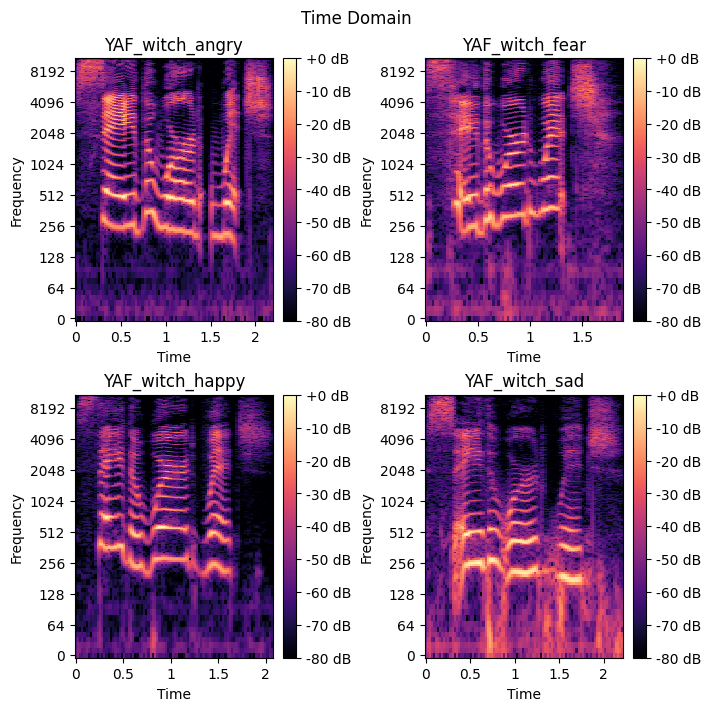

In [9]:
fig, axs = plt.subplots(2,2, constrained_layout=True, figsize=(7,7))
fig.suptitle("Time Domain")
for i,sample in enumerate(random_samples):
    signal, sample_rate = librosa.load(sample)
    if (i == 0):
        ax = axs[0,0]
    elif (i == 1):
        ax = axs[0,1]
    elif (i == 2):
        ax = axs[1,0]
    else:
        ax = axs[1,1]
    ax.set_title(sample.split('/')[2].split('.')[0])

    D = librosa.stft(signal)
    S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
    librosa.display.specshow(S_db, x_axis='time', y_axis='log')

    fig.colorbar(librosa.display.specshow(S_db, x_axis='time', y_axis='log', ax=ax), ax=ax, format="%+2.f dB")
    ax.set_xlabel('Time')
    ax.set_ylabel('Frequency')
plt.show()

Step 3: Acoustic Feature Extraction

In [65]:
# Time domain feature extraction (Zero-crossing Rate, root-mean-square energy)
signal, sample_rate = librosa.load(random_samples[1])
df = pd.DataFrame()

In [66]:
signal.shape
S, phase = librosa.magphase(librosa.stft(signal, win_length=25, hop_length=10))
S.shape
rms = librosa.feature.rms(S=S)
df['Loudness'] = rms[0]

In [67]:
zcr = librosa.feature.zero_crossing_rate(y=signal, frame_length=25, hop_length=10)
df['ZCR'] = zcr[0]

In [69]:
# Normalize column values to range [-1,1]
def normalize(df):
    for column in df.columns:
        df[column] = ((df[column] - df[column].min()) / (df[column].max() - df[column].min())) * 2 - 1
    return df

In [70]:
df = normalize(df)

In [91]:
# Concatenate features into numpy array
def concat_features(df):
    arr = np.array([])
    for i in range(len(df)):
        arr = np.append(arr, df.iloc[i])
    return arr

In [92]:
feature_arr = concat_features(df)

In [99]:
# Feature averaging
def average_features(arr, time_window, n_features):
    avg_arr = np.array([])
    temp_arr_1 = arr[0:len(arr) - (len(arr) % (time_window * n_features))]
    temp_arr_2 = arr[len(arr) - (len(arr) % (time_window * n_features)):len(arr)]
    return np.average(arr.reshape(-1, time_window * n_features), axis=1)

In [100]:
feature_arr_avg = average_features(feature_arr, 10, 2)

ValueError: cannot reshape array of size 8370 into shape (20)

In [ ]:
# Time-frequency domain feature extraction (mfccs, mel-spectogram)